In [1]:
#imports 
import numpy as np
import matplotlib.pyplot as plt
from time import process_time 
from matplotlib.lines import Line2D
from time import process_time

In [2]:
def make_moons(n_samples=10000, noise_sd=None, random_state=None):

    if isinstance(n_samples, int):
        n_samples_out = int(n_samples / 2)
        n_samples_in = n_samples - n_samples_out
    else:
        try:
            n_samples_out, n_samples_in = n_samples
        except ValueError as e:
            raise ValueError(
                "`n_samples` can be either an int or a two-element tuple."
            ) from e
    
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))             #x1 of class purple # -1 to 1
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))             #x2 of class purple # 0 to 1 to 0
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))          #x1 of class yellow # 0 to 2
    inner_circ_y = - np.sin(np.linspace(0, np.pi, n_samples_in))            #x2 of class yellow # -1 to 0

    X = np.vstack([np.append(outer_circ_x, inner_circ_x), np.append(outer_circ_y, inner_circ_y)]).T
    y = np.hstack((-np.ones(n_samples_out, dtype=np.intp), np.ones(n_samples_in, dtype=np.intp)))
    y = np.reshape(y,(-1,1))

    if noise_sd is not None:
        np.random.seed(random_state)
        X += np.random.normal(0, noise_sd, X.shape)

    label_proportion = 0.01  #####################################
    num_labeled = int(len(y)*label_proportion)
    xy = np.hstack([X,y])
    np.random.seed(random_state) #######################################################
    l_i1 = np.random.randint(low=0,high=n_samples_out,size=int(num_labeled/2))
    l_i2 = np.random.randint(low=n_samples_out+1,high=n_samples,size=int(num_labeled/2))
    l_i = np.hstack((l_i1,l_i2))
    u_i = ~np.isin(np.arange(X.shape[0]), l_i)
    
    x_labeled, y_labeled = xy[l_i,:2] , xy[l_i, -1:]
    x_unlabeled, y_unlabeled = xy[u_i, :2], xy[u_i, -1:]
    

    return x_labeled, x_unlabeled, y_labeled, y_unlabeled


x_labeled, x_unlabeled, y_labeled, y_unlabeled = make_moons(n_samples=10000, noise_sd= 0.15, random_state=41)


In [3]:
y_unlabeled = y_unlabeled[:,0]
y_labeled = y_labeled[:,0]

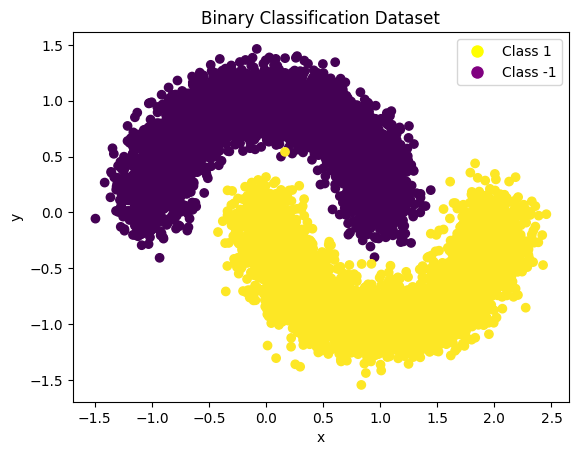

In [4]:
# Create a scatter plot of the data
def plot_xy(X,y):
  plt.scatter(X[:, 0], X[:, 1], c=y)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('Binary Classification Dataset')
  legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class 1', markerfacecolor='yellow', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Class -1', markerfacecolor='purple', markersize=10)]
  plt.legend(handles=legend_elements, loc='upper right')
  plt.show()
plot_xy(x_unlabeled,y_unlabeled)

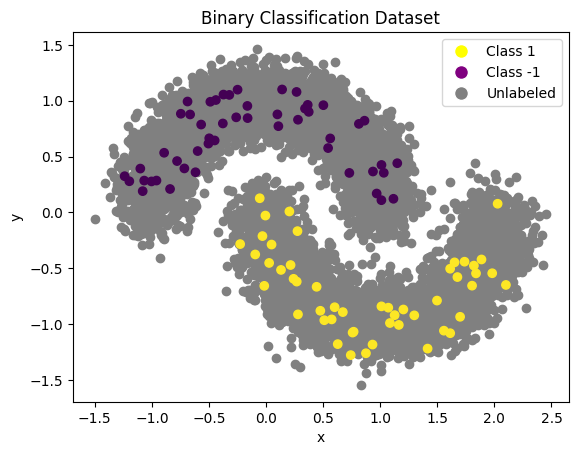

In [5]:
plt.scatter(x_unlabeled[:,0],x_unlabeled[:,1],c="gray")
plt.scatter(x_labeled[:, 0], x_labeled[:, 1], c=y_labeled)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Binary Classification Dataset')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class 1', markerfacecolor='yellow', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Class -1', markerfacecolor='purple', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Unlabeled', markerfacecolor='gray', markersize=10)
                   ]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()
plt.show()

In [2]:
def euclidean_distance(x,y, squared=True):
    x = x[:, None, :]
    y = y[None, :,:]
    dis = np.linalg.norm(x-y, ord=2, axis= -1) # using numpy broadcasting
    if squared:
        return np.power(dis,2)
    return dis

In [3]:
def simirality_weights(x_labeled,x_unlabeled, C=100):
    weights_l_u = np.exp(-C*euclidean_distance(x_labeled,x_unlabeled, squared=True)) #We should check the best hyperparamter C
    weights_u_u = np.exp(-C*euclidean_distance(x_unlabeled,x_unlabeled))
    return weights_l_u,weights_u_u
# weights_l_u,weights_u_u = simirality_weights(x_labeled,x_unlabeled)

In [9]:
# np.save('weights_l_u', weights_l_u)
# np.save('weights_u_u', weights_u_u)

In [10]:
weights_l_u = np.load('weights_l_u.npy')
weights_u_u = np.load('weights_u_u.npy')

### Function
$$
f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2
$$

In [4]:
def fy(y_unlabeled,y_labeled):
    tot1 = np.sum(weights_l_u.T * (y_unlabeled[:, np.newaxis] - y_labeled) ** 2)
    tot2 = np.sum(weights_u_u * (y_unlabeled[:, np.newaxis] - y_unlabeled) ** 2)
    return tot1 + tot2/2

In [5]:
##Hessian
def c_hessian(weights_l_u,weights_u_u):
    hessian= -weights_u_u.copy()
    for i in range(len(y_unlabeled)):
        hessian[i,i]=2*np.sum(weights_l_u[:,i]) + np.sum(weights_u_u[:,i]) - weights_u_u[i,i]
    return hessian
hessian = c_hessian(weights_l_u,weights_u_u)
hessian

In [12]:
# compute the eigenvalues of the Hessian matrix
import scipy
eigenvalues = scipy.linalg.eigvalsh(hessian)
L = max(eigenvalues)
sigma = min(eigenvalues)
alpha= 1/L
print(alpha)

0.007100773858992124


In [13]:
# np.save('alpha', alpha)

In [16]:
alpha = np.load('alpha.npy')
alpha

array(0.00710077)

## Gradient 

$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})y^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [17]:
c1=2*(np.sum(weights_l_u,axis=0))+ np.sum(weights_u_u,axis=0)
c2= 2*(weights_l_u*(y_labeled).reshape((-1,1))).sum(0)
def gradient(y_u):
    c3 = ((weights_u_u*y_u.reshape((-1,1))).sum(0)).reshape(-1,)
    return c1 * y_u -c2 -c3

In [18]:
def accuracy(y_u):
  y_a = y_u.copy()
  threshold=0
  y_a[y_a<threshold]=-1
  y_a[y_a>threshold]=1
  return sum(y_a==y_unlabeled)/100

In [19]:
def GS(y_u,y_l):
    eps = 1.0e-4
    max_iter= 100
    time_vec=[0]
    f_vec=[fy(y_u,y_l)]
    acc_vec=[accuracy(y_u)]
    g = gradient(y_u)

    time_start= process_time()
    
    for it in range(1,max_iter):
        check_stop= np.linalg.norm(g)
        if (check_stop<= eps):
          break
        y_u= y_u - alpha*g
        f_it=fy(y_u,y_l)
        f_vec.append(f_it)
        acc_vec.append(accuracy(y_u))
        g = gradient(y_u)
        time_vec.append(process_time() - time_start)

        #print(it)
         
    return y_u,f_vec,time_vec,acc_vec,check_stop

In [28]:
#flag=True we are computing the accuracy, flag=False we are computing the different values of the function
np.random.seed(41)
def initialize_points(flag):
  if flag==True:
    y_unlabeled_initial = np.random.choice([-1, 1], size=(len(x_unlabeled),))
  else:
    y_unlabeled_initial = np.zeros(len(y_unlabeled))
  return y_unlabeled_initial

In [22]:
y_unlabeled_initial = initialize_points(False)
y_unlabeled_initial_random = y_unlabeled_initial.copy()
y_unlabeled_initial_GS = y_unlabeled_initial.copy()


In [23]:
y_unlabel_final,f_vec,time_vec,acc_vec,gnr=GS(y_unlabeled_initial,y_labeled)


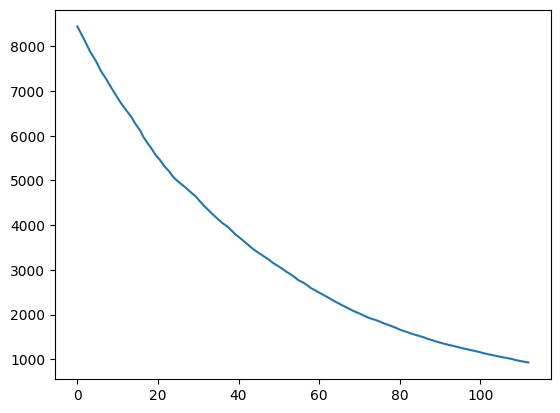

In [24]:
plt.plot(time_vec,f_vec)

In [25]:

threshold=0
y_unlabel_final[y_unlabel_final<threshold]=-1
y_unlabel_final[y_unlabel_final>threshold]=1
y_unlabel_final


array([-1., -1., -1., ...,  1.,  1.,  1.])

In [26]:

sum(y_unlabel_final==y_unlabeled)/100


98.98

In [27]:
X_u_final = np.hstack((x_unlabeled[:,:2],y_unlabel_final.reshape((-1,1))))
X_u_final


array([[ 0.95939315,  0.01572721, -1.        ],
       [ 1.03757897, -0.13815155, -1.        ],
       [ 1.08507076, -0.15477014, -1.        ],
       ...,
       [ 2.17638574, -0.23043133,  1.        ],
       [ 2.00437668,  0.34472221,  1.        ],
       [ 2.01152177, -0.26629976,  1.        ]])

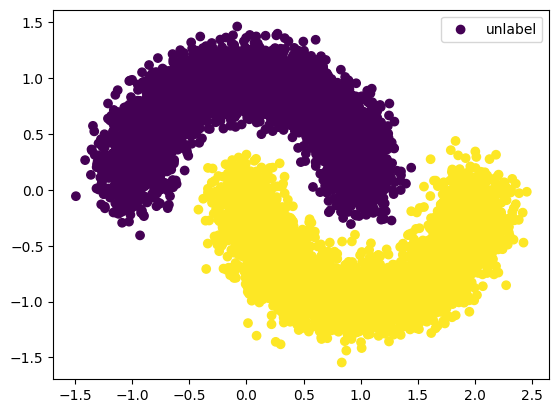

In [28]:
_ = plt.scatter(X_u_final[:,0],X_u_final[:,1],label=str("unlabel"),c=X_u_final[:,2])
#_ = plt.scatter([x[0] for x in X_l[y_l==1]],[x[1] for x in X_l[y_l==1]],label=str("1"),c="#1f77b4")
#_ = plt.scatter([x[0] for x in X_l[y_l==-1]],[x[1] for x in X_l[y_l==-1]],label=str("-1"),c="orange")
_ = plt.legend()

In [29]:
#If replacement=False --> random permutation, if replacement=True --> random sampling
def choice_randomized2(replacement):
  num_it = 100
  indexes = np.array([])
  for i in range(num_it+1):
    indexes_k = np.random.choice(len(y_unlabeled), len(y_unlabeled),replace=replacement)
    indexes = np.concatenate((indexes,indexes_k))
  return indexes.astype(int)

indexes = choice_randomized2(True)
indexes

array([1984,  931, 4066, ..., 2172, 6100, 5953])

In [30]:
def BCGD_Randomized(y_u, y_l,indexes):
    eps = 1.0e-4
    max_iter = 100 * len(y_u)
    time_vec = [0]
    f_vec = [fy(y_u, y_l)]
    g = gradient(y_u)
    alphas= np.full(max_iter,alpha)

    time_start = process_time()

    for it in range(1,max_iter+1):
        check_stop= np.linalg.norm(g)
        if (check_stop<= eps):
          break
        index = indexes[it]
        d = -g[index]
        y_u[index] += alphas[index] * d
        step = alphas[index]*g[index]
        g += weights_u_u[index]*step
        g[index] -= c1[index]*step
        i = it % len(y_u)
        if i == 0:
            f_it = fy(y_u, y_l)
            f_vec.append(f_it)
            time_vec.append(process_time() - time_start)
            #print(it / len(y_u))
            #print(f_it)

    return y_u, f_vec, time_vec, check_stop

In [31]:
y_unlabel_final_BCGD_RM,f_vec_BCGD_RM,time_vec_BCGD_RM,check_stop=BCGD_Randomized(y_unlabeled_initial_random,y_labeled,indexes)

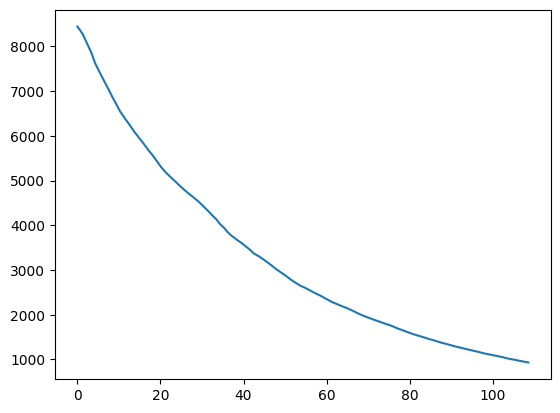

In [32]:
plt.plot(time_vec_BCGD_RM,f_vec_BCGD_RM)
#plt.plot(range(len(f_vec),f_vec))

In [33]:
def BCGD_GS_final(y_u, y_l):
    eps = 1.0e-4
    max_iter = 100 * len(y_u)
    time_vec = [0]
    f_vec = [fy(y_u, y_l)]
    g = gradient(y_u)

    time_start = process_time()

    for it in range(1,max_iter+1):
        check_stop= np.linalg.norm(g)
        if (check_stop<= eps):
          break
        index = np.argmax(np.abs(g))
        d = -g[index]
        y_u[index] += alpha * d
        step = alpha*g[index]
        g += weights_u_u[index]*step
        g[index] -= c1[index]*step
        i = it % len(y_u)
        if i == 0:
            f_it = fy(y_u, y_l)
            f_vec.append(f_it)
            time_vec.append(process_time() - time_start)
            #print(it / len(y_u))
            #print(f_it)

    return y_u, f_vec, time_vec, check_stop

In [34]:
y_unlabel_final_GS,f_vec_GS,time_vec_GS,check_stop=BCGD_GS_final(y_unlabeled_initial_GS,y_labeled)


In [ ]:
plt.plot(time_vec_GS,f_vec_GS)

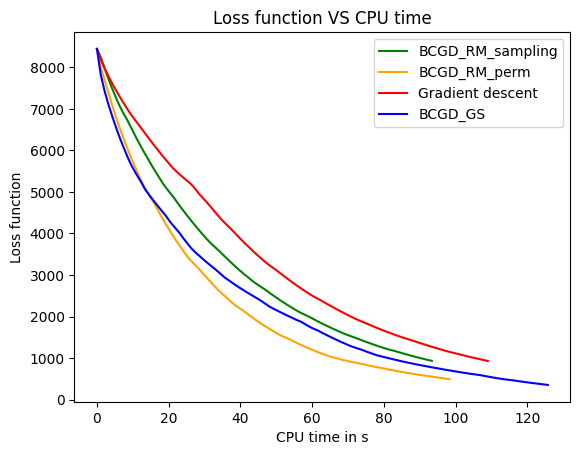

In [ ]:
plt.plot(time_vec_BCGD_RM,f_vec_BCGD_RM,label="BCGD_RM_sampling",color="green")
plt.plot(time_vec_BCGD_perm, f_vec_BCGD_perm,label="BCGD_RM_perm",color="orange")
plt.plot(time_vec,f_vec,label="Gradient descent",color="red")
plt.plot(time_vec_GS,f_vec_GS,label="BCGD_GS",color="blue")
plt.title("Loss function VS CPU time")
plt.xlabel("CPU time in s")
plt.ylabel("Loss function")
plt.legend()

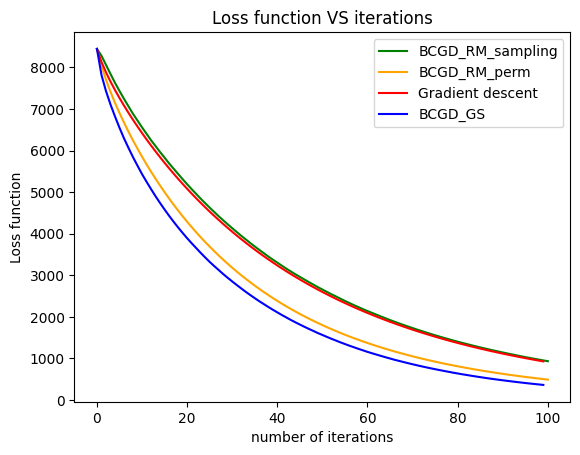

In [ ]:
plt.plot(np.arange(0,101),f_vec_BCGD_RM,label="BCGD_RM_sampling",color="green")
plt.plot(np.arange(0,101), f_vec_BCGD_perm,label="BCGD_RM_perm",color="orange")
plt.plot(np.arange(0,100),f_vec,label="Gradient descent",color="red")
plt.plot(np.arange(0,100),f_vec_GS[:100],label="BCGD_GS",color="blue")
plt.title("Loss function VS iterations")
plt.xlabel("number of iterations")
plt.ylabel("Loss function")
plt.legend()

## Real data set

In [6]:
import pandas as pd
path = "/content/Smoker_dataset.csv"
data = pd.read_csv(path)
data

FileNotFoundError: [Errno 2] No such file or directory: '/content/Smoker_dataset.csv'

# New section

In [ ]:
data.dropna(inplace=True)
data.type = data.type.map(lambda x: 1 if x=='Smoker' else -1)
data.Condition = data.Condition.map(lambda x: 1 if x=='Cancer' else -1)


In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import f_regression
X = data.values[:,:-1]
y = data.values[:,-1]
X_new = SelectKBest(score_func=f_regression, k=2).fit_transform(X,y)
X_new = SelectKBest(score_func=mutual_info_classif,k=2).fit_transform(X_new,y)

In [ ]:
from sklearn.model_selection import train_test_split
def split_data(X,y):
  x_unlabeled, x_labeled, y_unlabeled, y_labeled = train_test_split(X_new, y, test_size=0.03, stratify=y,random_state=41)
  return x_unlabeled, x_labeled, y_unlabeled, y_labeled

In [ ]:
x_unlabeled, x_labeled, y_unlabeled, y_labeled = split_data(X_new,y)

In [ ]:
#After defined new y_labeled and y_unlabeled run everything from the euclidean distance on 

## House prices - Mehran

In [5]:
import pandas as pd 

In [6]:
df = pd.read_csv('Housing.csv')

In [7]:
df.drop(columns=['ZN', 'INDUS', 'CHAS', 'RAD', 'TAX', 'B', 'LSTAT'], inplace=True)

In [8]:
def remove_outlier(df, col_names):
    for col_name in col_names:
        q1 = df[col_name].quantile(0.25)
        q3 = df[col_name].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df = df.loc[(df[col_name] > fence_low) & (df[col_name] < fence_high)]
        return df

In [9]:
df = df.dropna()
df = remove_outlier(df, ['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'PTRATIO'])

In [10]:
df_label = df['MEDV']
df.drop(columns=['MEDV'], inplace=True)

In [11]:
normalized_df=(df-df.min()) * 5 /(df.max()-df.min())

In [12]:
normalized_df.describe()

,CRIM,NOX,RM,AGE,DIS,PTRATIO
count,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000
mean,0.659017,1.557328,2.669330,3.185974,1.355346,2.973976
std,1.177220,1.151955,0.647404,1.439940,0.948992,1.176125
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.034846,0.617284,2.265760,1.925850,0.587165,2.127660
50%,0.096177,1.337449,2.556045,3.475798,1.146823,3.191489
75%,0.528845,2.057613,2.951715,4.536560,1.948867,4.042553
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [13]:
df_label = df_label.map(lambda x: x < df_label.median()).map({True:1, False:0})

In [14]:
from sklearn.utils import shuffle
df = pd.concat([normalized_df, df_label], axis=1)
df = shuffle(df)

In [15]:
x_labeled, x_unlabeled = np.array(df.iloc[:44,:-1].values), np.array(df.iloc[44:,:-1].values) 
y_labeled, y_unlabeled = np.array(df.iloc[:44,-1].values), df.iloc[44:, -1].values

In [16]:
x_labeled.shape , x_unlabeled.shape , y_labeled.shape, y_unlabeled.shape

((44, 6), (393, 6), (44,), (393,))

In [17]:
weights_l_u,weights_u_u = simirality_weights(x_labeled,x_unlabeled, C=2)

In [18]:
weights_l_u.shape

(44, 393)

In [19]:
import scipy

In [29]:
##Hessian
def c_hessian(weights_l_u,weights_u_u):
    hessian= -weights_u_u.copy()
    for i in range(len(y_unlabeled)):
        hessian[i,i]=2*np.sum(weights_l_u[:,i]) + np.sum(weights_u_u[:,i]) - weights_u_u[i,i]
    return hessian
hessian = c_hessian(weights_l_u,weights_u_u)

In [30]:
hessian = c_hessian(weights_l_u,weights_u_u)
eigenvalues = scipy.linalg.eigvalsh(hessian)
L = max(eigenvalues)
sigma = min(eigenvalues)
alpha= 1/L
print(alpha)

0.05995510235441919


In [31]:
def accuracy(y_u):
  y_a = y_u.copy()
  threshold=0
  y_a[y_a<threshold]=-1
  y_a[y_a>threshold]=1
  return sum(y_a==y_unlabeled)/100



def GS(y_u,y_l):
    eps = 1.0e-4
    max_iter= 100
    time_vec=[0]
    f_vec=[fy(y_u,y_l)]
    acc_vec=[accuracy(y_u)]
    g = gradient(y_u)

    time_start= process_time()
    
    for it in range(1,max_iter):
        check_stop= np.linalg.norm(g)
        if (check_stop<= eps):
          break
        y_u= y_u - alpha*g
        f_it=fy(y_u,y_l)
        f_vec.append(f_it)
        acc_vec.append(accuracy(y_u))
        g = gradient(y_u)
        time_vec.append(process_time() - time_start)

        #print(it)
         
    return y_u,f_vec,time_vec,acc_vec,check_stop


In [32]:
c1=2*(np.sum(weights_l_u,axis=0))+ np.sum(weights_u_u,axis=0)
c2= 2*(weights_l_u*(y_labeled).reshape((-1,1))).sum(0)
def gradient(y_u):
    c3 = ((weights_u_u*y_u.reshape((-1,1))).sum(0)).reshape(-1,)
    return c1 * y_u -c2 -c3

In [33]:
#flag=True we are computing the accuracy, flag=False we are computing the different values of the function
np.random.seed(41)
def initialize_points(flag):
  if flag==True:
    y_unlabeled_initial = np.random.choice([-1, 1], size=(len(x_unlabeled),))
  else:
    y_unlabeled_initial = np.zeros(len(y_unlabeled))
  return y_unlabeled_initial

In [34]:
y_unlabeled_initial = initialize_points(False)
y_unlabeled_initial_random = y_unlabeled_initial.copy()
y_unlabeled_initial_GS = y_unlabeled_initial.copy()

In [35]:
y_unlabel_final,f_vec,time_vec,acc_vec,gnr=GS(y_unlabeled_initial,y_labeled)

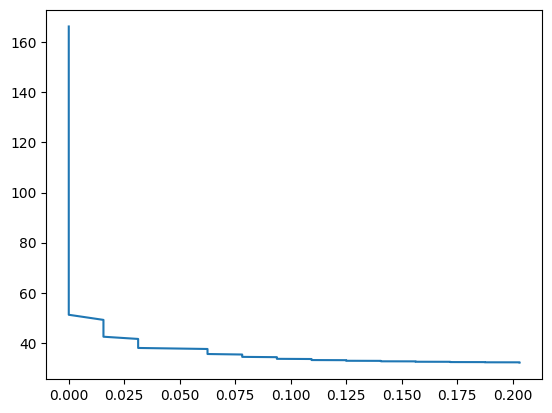

In [36]:
plt.plot(time_vec,f_vec)